# BINTANGKECILPAPA

## Strategy Analysis

### Background
Fall detection is an important function that should be present in any environment that has a high risk of falls happening, like an elderly persons living quarters, because it is of utmost importance to deliver fast response in case of an emergency.

### Strategy
i. To detect falling in a static frame, we utilize **pose estimation** to detect the posture of the subject within the frame. We use this method due to **5 major driving factor**:

1. **Most Parameters are Irrelevant or even harmful towards fall detection** :  A fall is defined by the specific conditions the body of a subject is in. Parameters such as background and lighting does not provide that data and in cluttered environments, background elements such as furnitures, walls, and other objects can ruin precision.

2. **Pose Detection Captures Key Fall Indicators** : Pose detection enable precise analysis of the subject's body condition.

3. **Robustness towards noise** : Pose detection methods isolate the subjects skeletal data and ignores environmental elements that acts as noise and ruin precision.

4. **Computational Efficiency** : Processing skeletal data is simpler than analyzing the entire image frame, including the background, as it is stored in the form of an array of coordinates.

5. **Generalization Across Scenarios** : Pose detection ensures that fall detection works across various environments (e.g., homes, hospitals, outdoor settings) without retraining for each background as it ignores external elements.

ii. Afterwards, the **pose detection** data is stored in a dataframe and cleaned. 

iii. Subsequently, the cleaned data is used to create *features* in the feature creation process. These features include:
1. Angles between limbs
2. Tilt of body
3. Distance between feet and head
4. X and Y ratio of the bounding box
5. Center of gravity
6. Relative head position

iv. Lastly, the data is used to train a **gradient boosting model using xgboost**, this model is used mainly due to **4 major reasons**:

1. **Captures Non-Linear Relationships**
2. **Compatibility with single-frame non temporal data**
3. **Less required data** : Gradient boosting models requires less data to perform well, compared to deep learning models
5. **Ability to Handle Class Imbalances** : In fall detection datasets, falls are often less frequent than non-fall cases, leading to class imbalance

## Importing Libraries

In [776]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

import xgboost as xgb

## Data Generation

### Image Generation

### Dataframe Generation

In [777]:
# if not os.path.exists("renamed"):
#     os.makedirs("renamed")

# organize_file("train/", "renamed/")

# generate_df("renamed/", "train.csv")

# generate_df("test/", "test.csv")

## Importing Dataset

In [778]:
df = pd.read_csv('train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.544754,0.318781,-0.316802,0.548357,0.297941,-0.310290,0.551080,0.297644,-0.310276,0.553934,...,0.510525,0.826604,0.212844,0.559476,0.869833,0.175274,0.510115,0.876290,0.119978,0.0
1,0.505908,0.222317,-0.271784,0.506973,0.208480,-0.260697,0.508966,0.208614,-0.260694,0.510773,...,0.487880,0.686196,0.240492,0.518907,0.710326,0.193727,0.477986,0.722992,0.158466,0.0
2,0.506167,0.235364,-0.305863,0.506347,0.213392,-0.296672,0.508419,0.213194,-0.296663,0.510347,...,0.485434,0.689417,0.273322,0.519498,0.720146,0.239598,0.475444,0.725814,0.196817,0.0
3,0.548427,0.305591,-0.304227,0.551090,0.286561,-0.295931,0.553961,0.286860,-0.295922,0.557000,...,0.509223,0.829900,0.217705,0.550646,0.881033,0.151391,0.508013,0.880252,0.122250,0.0
4,0.544850,0.291295,-0.290476,0.548933,0.269728,-0.282204,0.551873,0.270585,-0.282188,0.555235,...,0.509063,0.822003,0.232308,0.553189,0.874124,0.177339,0.507485,0.875083,0.136912,0.0


In [779]:
def assign_columns(df: pd.DataFrame, train: bool = True) -> list:
    new_columns = []
    coordinate = ["x", "y", "z"]
    counts = [0, 0, 0]
    for i in range(len(df.columns)):
        if (i == len(df.columns) - 1) and train:
            new_columns.append("label")
        else:
            idx = i % 3
            new_columns.append(coordinate[idx] + str(counts[idx]))
            counts[idx] += 1
    return new_columns

df.columns = assign_columns(df)
df.dropna(subset=["label"], inplace=True)

## Exploratory Data Analysis

In [780]:
df.describe()

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,x30,y30,z30,x31,y31,z31,x32,y32,z32,label
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,...,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000
mean,0.521771,0.506292,-0.135950,0.523250,0.498101,-0.133278,0.523880,0.497940,-0.133288,0.524519,...,0.457206,0.779598,0.109305,0.479501,0.786489,0.117849,0.465484,0.793080,0.059493,0.363298
std,0.149844,0.229781,0.159241,0.152549,0.237530,0.157261,0.152526,0.237732,0.157250,0.152493,...,0.116134,0.137490,0.160174,0.120149,0.146510,0.179687,0.120270,0.146705,0.162983,0.480994
min,0.118351,0.130525,-1.112870,0.113984,0.124279,-1.080989,0.114864,0.125665,-1.080827,0.115830,...,0.137438,0.425276,-0.449853,0.193533,0.424292,-0.425301,0.172208,0.430112,-0.770852,0.000000
25%,0.467736,0.287738,-0.249778,0.469176,0.273390,-0.244203,0.468955,0.273351,-0.244236,0.469515,...,0.416977,0.716505,0.024860,0.432556,0.717386,-0.016612,0.423514,0.732896,-0.009578,0.000000
50%,0.520493,0.470549,-0.132306,0.521683,0.458797,-0.128748,0.522788,0.456656,-0.128736,0.523792,...,0.471231,0.788352,0.152427,0.504497,0.776247,0.155593,0.465952,0.788956,0.104015,0.000000
75%,0.623507,0.732457,-0.025569,0.629533,0.734078,-0.029021,0.629541,0.732453,-0.029061,0.629555,...,0.509963,0.838162,0.220736,0.546706,0.865118,0.259089,0.522795,0.871657,0.158466,1.000000
max,1.133347,1.031414,0.316095,1.105730,1.007555,0.323136,1.110313,1.006288,0.323141,1.114991,...,1.488506,3.886434,0.680001,1.607184,3.951123,0.664073,1.513458,3.955534,0.648402,1.000000


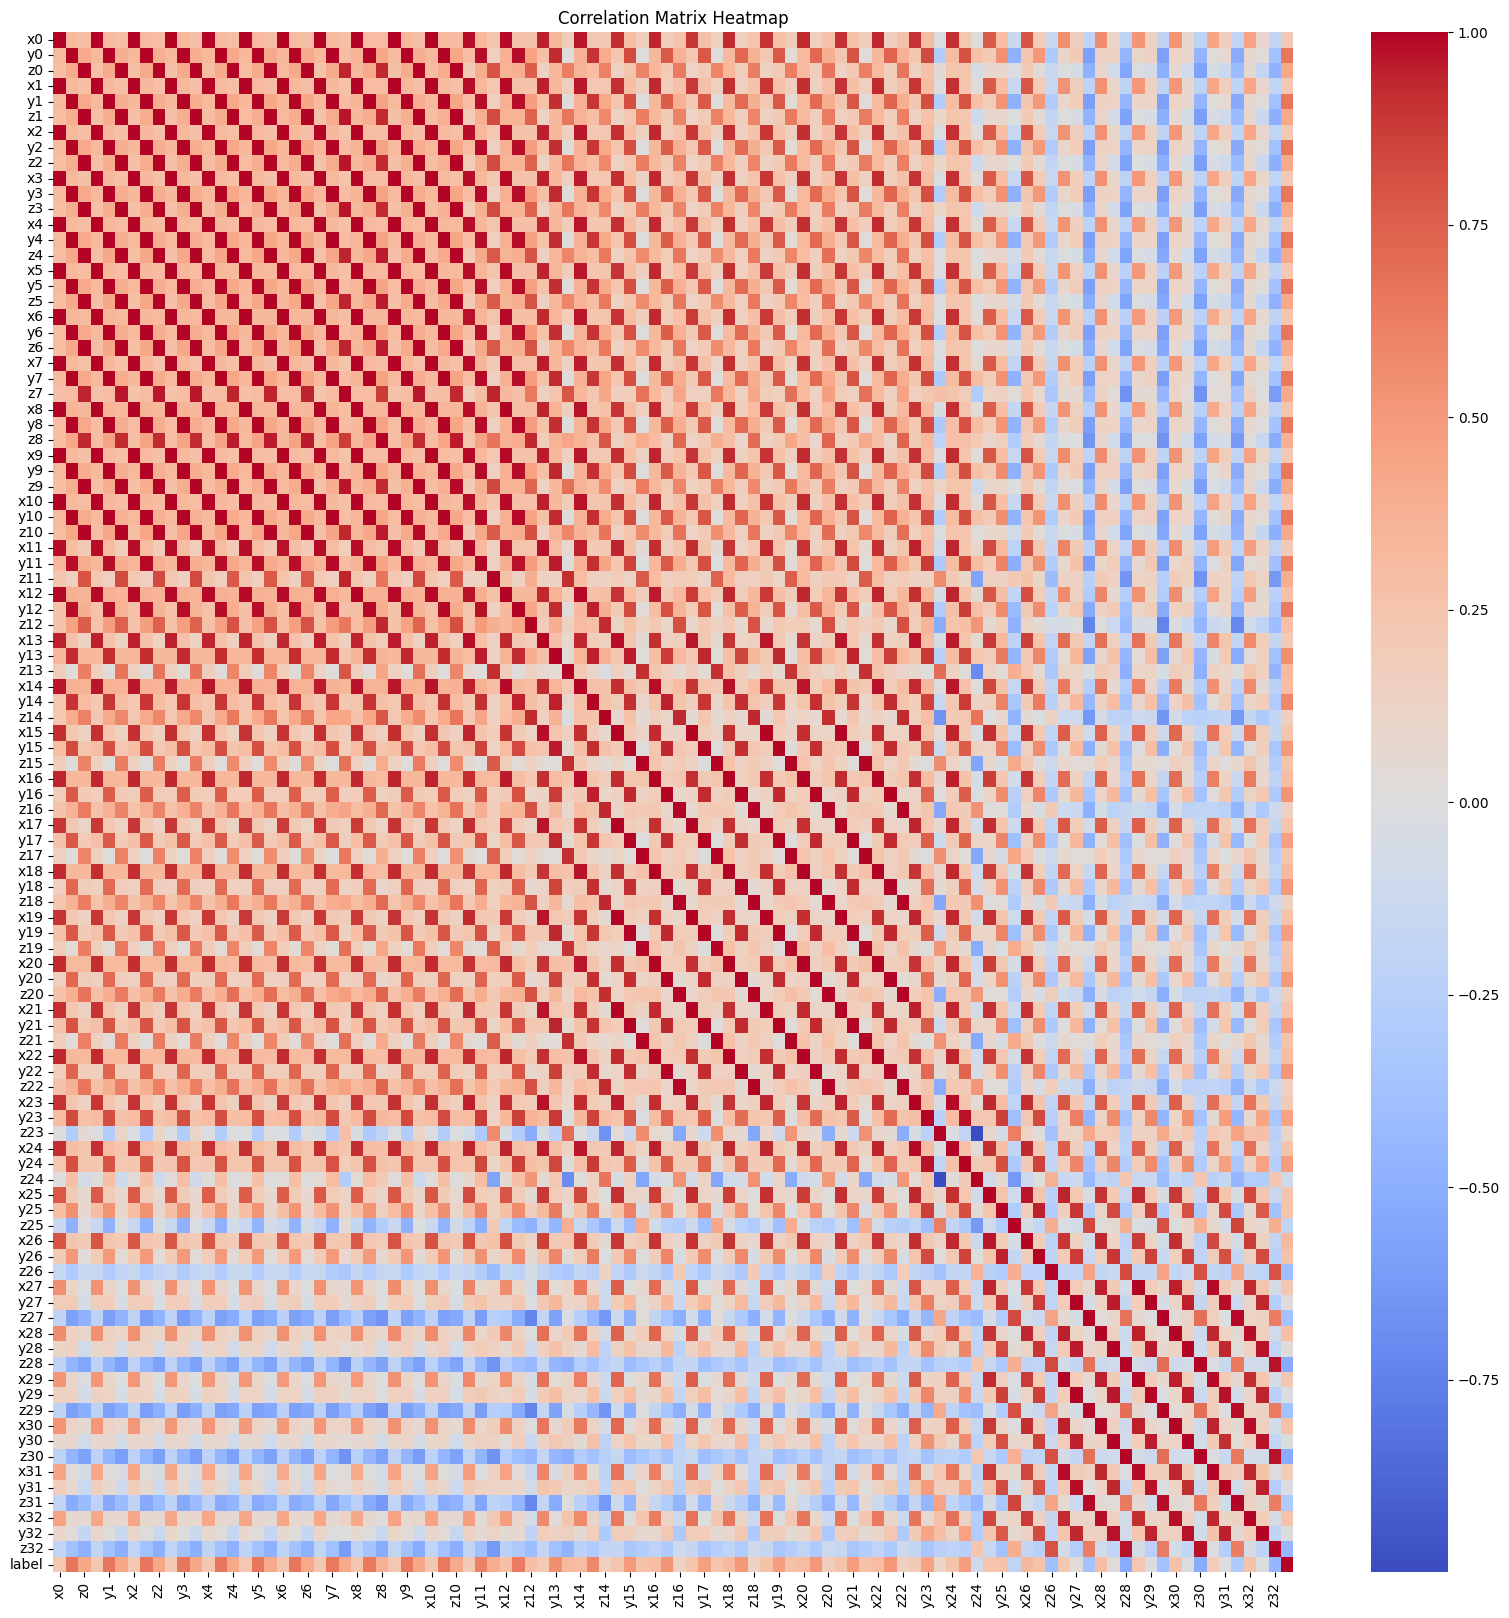

In [781]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

## Data Cleaning & Preprocessing

### Handling missing data

In [782]:
def remove_non_float(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy().applymap(lambda x: np.nan if isinstance(x, str) and any(c.isalpha() for c in x) else x)
    return ret

In [783]:
def set_data_type(df: pd.DataFrame) -> pd.DataFrame:
    return df.astype(float)

In [784]:
simple_imputer = SimpleImputer(strategy="median")

def simple_impute(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
    if train:
        labels = df["label"]
        features = df.drop("label", axis=1)

        imputed_data = simple_imputer.fit_transform(features)

        imputed_df = pd.DataFrame(imputed_data, columns=features.columns, index=df.index)
        imputed_df["label"] = labels
    else:
        imputed_data = simple_imputer.transform(df)
        imputed_df = pd.DataFrame(imputed_data, columns=df.columns, index=df.index)

    return imputed_df

### Removing Duplicates

In [785]:
def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    return ret.drop_duplicates()

### Feature Scaling

In [786]:
standard_scaler = StandardScaler()

def scale(df: pd.DataFrame, train:bool = False) -> pd.DataFrame:
  cols = [col for col in df.columns if col != "label"]
  ret = df.copy()
  if train:
    ret[cols] = standard_scaler.fit_transform(df[cols])
  else:
    ret[cols] = standard_scaler.transform(df[cols])
  return ret

In [787]:
def add_angles(df: pd.DataFrame) -> pd.DataFrame:
    def calculate_angle(x1: float, y1: float, x2: float, y2: float, x3: float, y3: float) -> float:
        radians = np.arctan2(y3 - y2, x3 - x2) - np.arctan2(y1 - y2, x1 - x2)
        angle = np.abs(radians * 180.0 / np.pi)
        
        if angle > 180.0:
            angle = 360 - angle
            
        return angle
    
    ret = df.copy()
    
    ret["angle0"] = ret.apply(
        lambda row: calculate_angle(row["x12"], row["y12"], row["x14"], row["y14"], row["x16"], row["y16"]),
        axis=1
    )
    ret["angle1"] = ret.apply(
        lambda row: calculate_angle(row["x11"], row["y11"], row["x13"], row["y13"], row["x15"], row["y15"]),
        axis=1
    )
    ret["angle2"] = ret.apply(
        lambda row: calculate_angle(row["x24"], row["y24"], row["x26"], row["y26"], row["x28"], row["y28"]),
        axis=1
    )
    ret["angle3"] = ret.apply(
        lambda row: calculate_angle(row["x23"], row["y23"], row["x25"], row["y25"], row["x27"], row["y27"]),
        axis=1
    )

    return ret

In [788]:
def add_gradient(df: pd.DataFrame) -> pd.DataFrame:
    def calculate_gradient(x1: float, y1: float, x2: float, y2: float) -> float:
        return (y2 - y1) / (x2 - x1)
    
    ret = df.copy()
    
    ret["gradient0"] = ret.apply(
        lambda row: calculate_gradient(row["x12"], row["y12"], row["x24"], row["y24"]),
        axis=1
    )
    ret["gradient1"] = ret.apply(
        lambda row: calculate_gradient(row["x24"], row["y24"], row["x23"], row["y23"]),
        axis=1
    )
    ret["gradient2"] = ret.apply(
        lambda row: calculate_gradient(row["x23"], row["y23"], row["x11"], row["y11"]),
        axis=1
    )
    ret["gradient3"] = ret.apply(
        lambda row: calculate_gradient(row["x11"], row["y11"], row["x12"], row["y12"]),
        axis=1
    )
    ret["gradient4"] = ret.apply(
        lambda row: calculate_gradient(row["x0"], row["y0"], row["x28"], row["y28"]),
        axis=1
    )
    ret["gradient5"] = ret.apply(
        lambda row: calculate_gradient(row["x0"], row["y0"], row["x27"], row["y27"]),
        axis=1
    )
    return ret


In [789]:
def add_distances(df: pd.DataFrame) -> pd.DataFrame:
    def calculate_distance(x1: float, y1: float, x2: float, y2: float) -> float:
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    ret = df.copy()
    ret["distance0"] = ret.apply(
        lambda row: calculate_distance(row["x0"], row["y0"], row["x28"], row["y28"]),
        axis=1
    )
    ret["distance1"] = ret.apply(
        lambda row: calculate_distance(row["x0"], row["y0"], row["x27"], row["y27"]),
        axis=1
    )
    return ret

In [790]:
def add_area(df: pd.DataFrame) -> pd.DataFrame:
    def get_width(row) -> float:
        min_x = float("inf")
        max_x = 0
        min_y = float("inf")
        max_y = 0
        for i in range(33):
            min_x = min(min_x, row[f"x{i}"])
            max_x = max(max_x, row[f"x{i}"])
            min_y = min(min_y, row[f"y{i}"])
            max_y = min(max_y, row[f"y{i}"])
        return ((max_x - min_x))
    
    def get_height(row) -> float:
        min_x = float("inf")
        max_x = 0
        min_y = float("inf")
        max_y = 0
        for i in range(33):
            min_x = min(min_x, row[f"x{i}"])
            max_x = max(max_x, row[f"x{i}"])
            min_y = min(min_y, row[f"y{i}"])
            max_y = min(max_y, row[f"y{i}"])
        return ((max_y - min_y))


    ret = df.copy()
    ret["width"] = ret.apply(get_width, axis=1)
    ret["height"] = ret.apply(get_height, axis=1)
    return ret

In [791]:
def add_relative_head_y(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.copy()
    ret["head_is_higher"] = ret["y0"] - ret[["y12", "y11"]].mean(axis=1)
    return ret

In [792]:
def add_head_height(df: pd.DataFrame) -> pd.DataFrame:
    def calculate_head_height(row):
        ret = 0
        for i in range(10):
            ret += row[f"y{i}"]
        return ret/10

    df["head_height"] = df.apply(calculate_head_height, axis=1)
    return df

### Data Pipeline

In [793]:
def pipeline(df: pd.DataFrame, train: bool = False) -> pd.DataFrame:
    df = remove_non_float(df)
    df = simple_impute(df, train)
    if train: df = df.dropna()
    df = set_data_type(df)
    if train: df = remove_duplicates(df)
    df = add_angles(df)
    df = add_gradient(df)
    df = add_distances(df)
    df = add_area(df)
    df = add_relative_head_y(df)
    df = add_head_height(df)
    # df = scale(df, train)
    return df

### Feature Selection

In [794]:
def feature_selection(df: pd.DataFrame) -> pd.DataFrame:
    return df[['y4', 'y5', 'y6', 'y0', 'y1', 'y2', 'head_height', 'y3', 'y10',
       'y9', 'y8', 'y7', 'y12', 'y11', 'y14', 'head_is_higher', 'angle3',
       'y13', 'y16', 'y22', 'z28', 'z30', 'y20', 'y18', 'width', 'height', 'y15', 'y21',
       'angle2', 'y19', 'y17', 'y24', 'distance1', 'distance0', 'y23', 'z9',
       'z32', 'z1', 'z2', 'z3', 'z0', 'z4', 'z7', 'z5', 'z6', 'z10', 'z11',
       'z8', 'z29', 'z26', 'z27', 'x26', 'z13', 'x18', 'x16', 'x20', 'x22',
       'x14', 'x28', 'angle0', 'z31', 'z19', 'x32', 'x30', 'z21', 'z15', 'z12',
       'z17', 'x12', 'x25', 'angle1', 'y26', 'y25', 'x24', 'x19', 'x21', 'x17',
       'x29', 'x27', 'x15', 'x8', 'x6', 'x10', 'x5', 'x4', 'x0', 'x31', 'x9',
       'x1', 'x2', 'x7', 'x3', 'x13', 'x23', 'z20', 'x11', 'z25', 'z22', 'z18',
       'z14']]

## Modelling

In [795]:
train_set, val_set = train_test_split(
    df, test_size = 0.2,
    random_state = 43,
    stratify = df['label'])

In [796]:
processed_train_set = pipeline(train_set, train=True)
X_train = processed_train_set.drop(columns = ['label'])
y_train = processed_train_set["label"]

X_val = val_set.drop(columns = ['label'])
X_val = pipeline(X_val)
y_val = val_set["label"]

In [797]:
X_train = feature_selection(X_train)
X_val = feature_selection(X_val)

In [798]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
import xgboost as xgb

# Define the classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, eta=0.4, max_depth=4)


# Define a cross-validation splitter with a fixed random_state
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring=make_scorer(accuracy_score))

# Print the mean accuracy and standard deviation
print(f"Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Cross-Validation Accuracy: 0.9847 ± 0.0047


## Submission

In [799]:
test = pd.read_csv('test.csv')
test_id = test["0"]
test_df = test.drop(columns = ["0"])
test_df.columns = assign_columns(test_df, False)

test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,00396960ae.jpg,0.506542,0.326502,-0.394809,0.510853,0.318827,-0.381523,0.514041,0.319245,-0.381544,...,-0.045714,0.478852,0.587050,0.120050,0.543383,0.628199,-0.127656,0.461230,0.596174,0.049492
1,004773d4e8.jpg,0.508381,0.318787,-0.285616,0.512454,0.309253,-0.278278,0.515418,0.310724,-0.278292,...,0.325308,0.498607,0.789300,0.299434,0.526203,0.816745,0.253037,0.495945,0.816318,0.219213
2,009b266d98.jpg,0.269181,0.865426,0.086088,0.263310,0.872093,0.101797,0.263721,0.871812,0.101744,...,0.114388,0.551513,0.949314,-0.098662,0.570517,0.860292,0.070581,0.571953,0.912558,-0.168820
3,009ed56c89.jpg,0.454379,0.316104,-0.155151,0.455576,0.312321,-0.150520,0.456627,0.313304,-0.150542,...,0.146733,0.434100,0.715720,0.125274,0.483431,0.724991,0.087355,0.432365,0.733243,0.057837
4,00a16cb3ae.jpg,0.512489,0.632591,-0.087677,0.518209,0.616437,-0.083471,0.518470,0.616599,-0.082422,...,-0.057040,0.489405,0.729642,0.010553,0.496941,0.765673,-0.086115,0.494453,0.743872,0.154348


In [800]:
processed_df = pipeline(df, True)

In [801]:
X_final = processed_df.drop(["label"], axis=1)
y_final = processed_df["label"]

In [802]:
processed_test = pipeline(test_df, False)

In [803]:
xgb_clf.fit(X_final, y_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.4, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [804]:
submission = xgb_clf.predict(processed_test)

In [805]:
submission_df = pd.concat([test_id, pd.Series(submission).astype(int)], axis=1)
submission_df.columns = ["id", "label"]

In [806]:
sample = pd.read_csv('sample_submission.csv')
sample.drop(columns = ["label"], inplace = True)

In [807]:
submit_csv = sample.merge(submission_df[['id', 'label']], on='id', how='left')

In [808]:
submit_csv.to_csv('submission.csv', index=False)

## Saving Model

In [811]:
xgb_clf.save_model("xgb_model.json")  # Save in JSON format

## Loading Model

In [812]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgb_model.json")